In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf

#### Cropping the images to remove background

In [2]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img

#### Creating a cropped folder in which cropped training and testing images are stored

In [3]:
if __name__ == "__main__":
	training = "Dataset/Trainingbrain"
	testing = "Dataset/Testingbrain"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256
	
	for dir in training_dir:
		save_path = 'Dataset/cropped/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'Dataset/cropped/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)


	

In [4]:
training_dir

['glioma', 'meningioma', 'notumor', 'pituitary']

#### Cropped images Demo 

In [5]:
img = cv2.imread('./Dataset/Trainingbrain/meningioma/Tr-me_0476.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

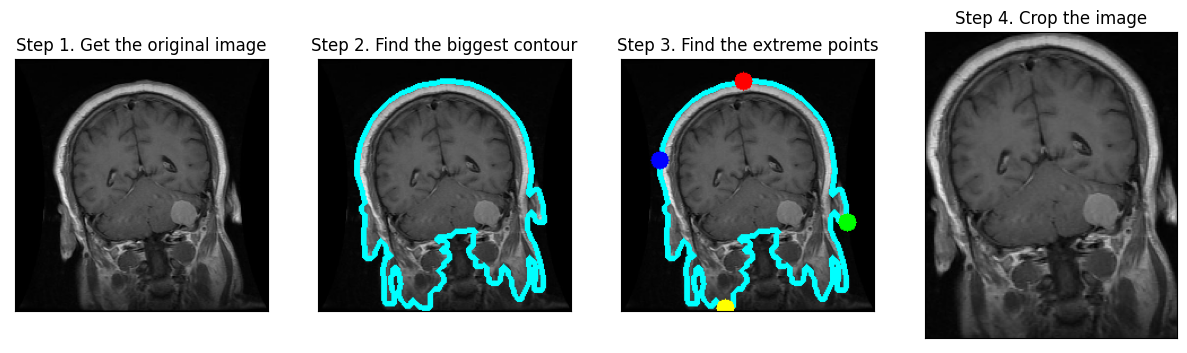

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 200
labels = ['glioma','meningioma','notumor','pituitary'] 
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Training',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_train.append(image)
        y_train.append(labels.index(i))
        
for i in labels:
    folderpath = os.path.join('./Dataset/Cropped/Testing',i)
    for j in os.listdir(folderpath):
        image = cv2.imread(os.path.join(folderpath,j),0) #load images in gray
        image = cv2.bilateralFilter(image,2,50,50) # remove noise image
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images
        X_test.append(image)
        y_test.append(labels.index(i))

X_train = np.array(X_train) / 255.0 # normalize Images into range 0 to 1.
X_test = np.array(X_test) / 255.0

print(X_train.shape)
print(X_test.shape)
        

(5712, 200, 200, 3)
(1311, 200, 200, 3)


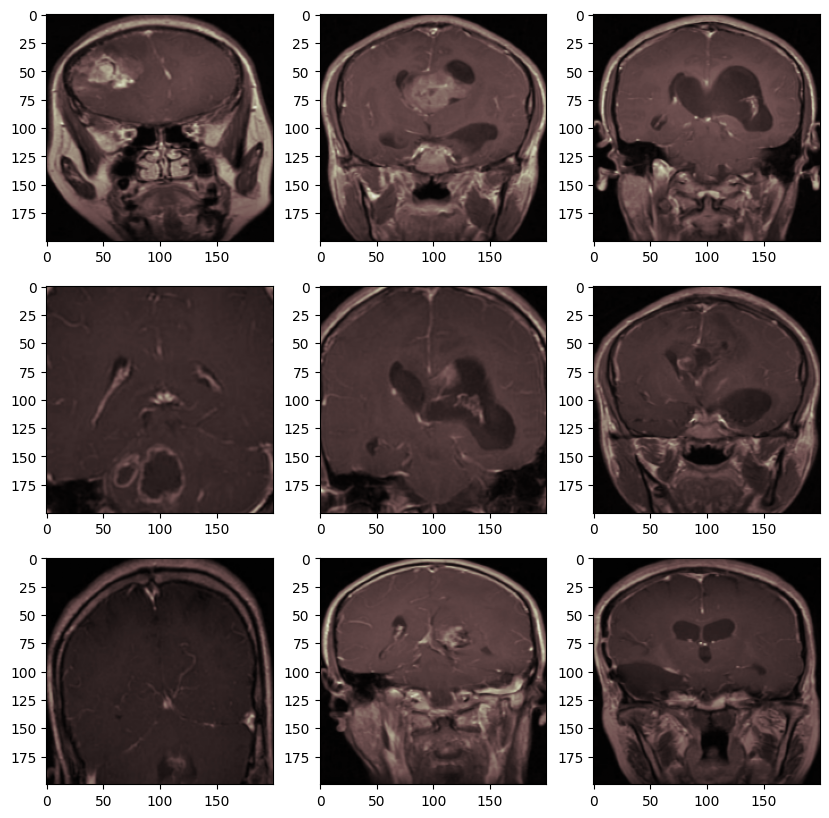

In [8]:
images = [X_train[i] for i in range(9)]
fig, axes = plt.subplots(3, 3, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
#plt.tight_layout()
plt.show()

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [10]:
X_train, y_train = shuffle(X_train,y_train, random_state=42) 

In [11]:
y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.
print(X_val.shape)
print(X_train.shape)
print(X_test.shape)

(1143, 200, 200, 3)
(4569, 200, 200, 3)
(1311, 200, 200, 3)


#### Image Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam

In [14]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(X_train)

#### Model Training

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
IMG_SIZE=(200,200)
base_model = InceptionV3(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in base_model.layers:
    layer.trainable = True

In [16]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
# Customized layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
predict = Dense(4,activation='softmax')(x)

# create a model object
model = Model(inputs = base_model.input,outputs = predict)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])

Optimizer Definition:
An instance of the Adam optimizer is defined here. Adam is a widely-used optimization algorithm in deep learning, known for its efficiency and computational effectiveness. It combines the benefits of both momentum and RMSProp, and adaptively adjusts the learning rate during training. By setting learning_rate=0.0001, a relatively small learning rate is specified, which can help the model converge more stably, albeit potentially requiring more epochs to reach optimal performance.

Model Compilation:
optimizer=adam: Specifies that the previously defined Adam optimizer should be used to perform backpropagation and weight updates during training.
loss='categorical_crossentropy': Chooses "categorical crossentropy" as the loss function. This is a commonly used loss function for multi-class classification problems, particularly when the output layer uses a softmax activation. Categorical crossentropy measures the difference between two probability distributions – in this case, the true distribution of labels versus the predicted probabilities by the model.

In [19]:
train_len = len(X_train)
val_len = len(X_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
4569
-----------Validation Data length-----------------
1143


In [20]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size=32),validation_data = (X_val,y_val),epochs = 25,verbose=1)

Epoch 1/25
143/143 [==============================] - 258s 2s/step - loss: 0.3974 - accuracy: 0.8439 - val_loss: 0.2819 - val_accuracy: 0.9134
Epoch 2/25
143/143 [==============================] - 253s 2s/step - loss: 0.1376 - accuracy: 0.9486 - val_loss: 0.1817 - val_accuracy: 0.9475
Epoch 3/25
143/143 [==============================] - 254s 2s/step - loss: 0.0707 - accuracy: 0.9742 - val_loss: 0.1178 - val_accuracy: 0.9738
Epoch 4/25
143/143 [==============================] - 253s 2s/step - loss: 0.0542 - accuracy: 0.9825 - val_loss: 0.1489 - val_accuracy: 0.9676
Epoch 5/25
143/143 [==============================] - 254s 2s/step - loss: 0.0398 - accuracy: 0.9866 - val_loss: 0.1254 - val_accuracy: 0.9755
Epoch 6/25
143/143 [==============================] - 253s 2s/step - loss: 0.0352 - accuracy: 0.9899 - val_loss: 0.0991 - val_accuracy: 0.9781
Epoch 7/25
143/143 [==============================] - 257s 2s/step - loss: 0.0291 - accuracy: 0.9906 - val_loss: 0.0934 - val_accuracy: 0.9808

#### Plotting output results

In [21]:
#Plotting the results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

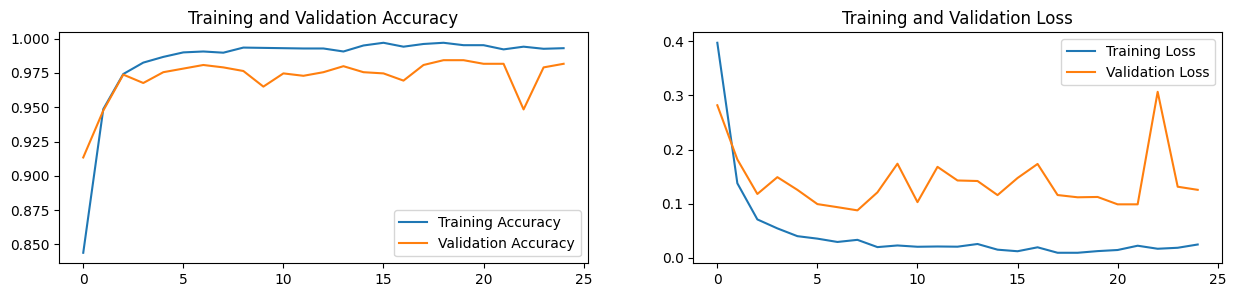

In [22]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc= "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc= "upper right")
plt.title("Training and Validation Loss")
plt.savefig('InceptionAccLoss.pdf', format='pdf')

In [23]:
#Saving the model
from keras.models import load_model
model.save('bestinception2.h5')

#### Validation on Test set

In [24]:
loss,acc = model.evaluate(X_test,y_test)

41/41 [==============================] - 12s 303ms/step - loss: 0.1050 - accuracy: 0.9855


#### Classification Report

In [25]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_classes = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

              precision    recall  f1-score   support

      glioma       0.98      0.99      0.98       300
  meningioma       0.98      0.97      0.98       306
    no_tumor       0.99      0.99      0.99       405
   pituitary       1.00      0.98      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.99      1311
weighted avg       0.99      0.99      0.99      1311



#### Confusion Matrix

164/164 [==============================] - 19s 117ms/step


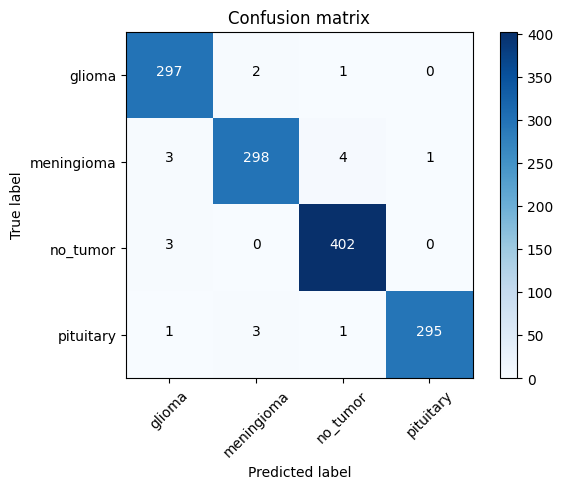

In [26]:
import itertools
pred_Y = model.predict(X_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 
plt.savefig('InceptionCM.pdf', format='pdf')

#### Plotting sample predictions

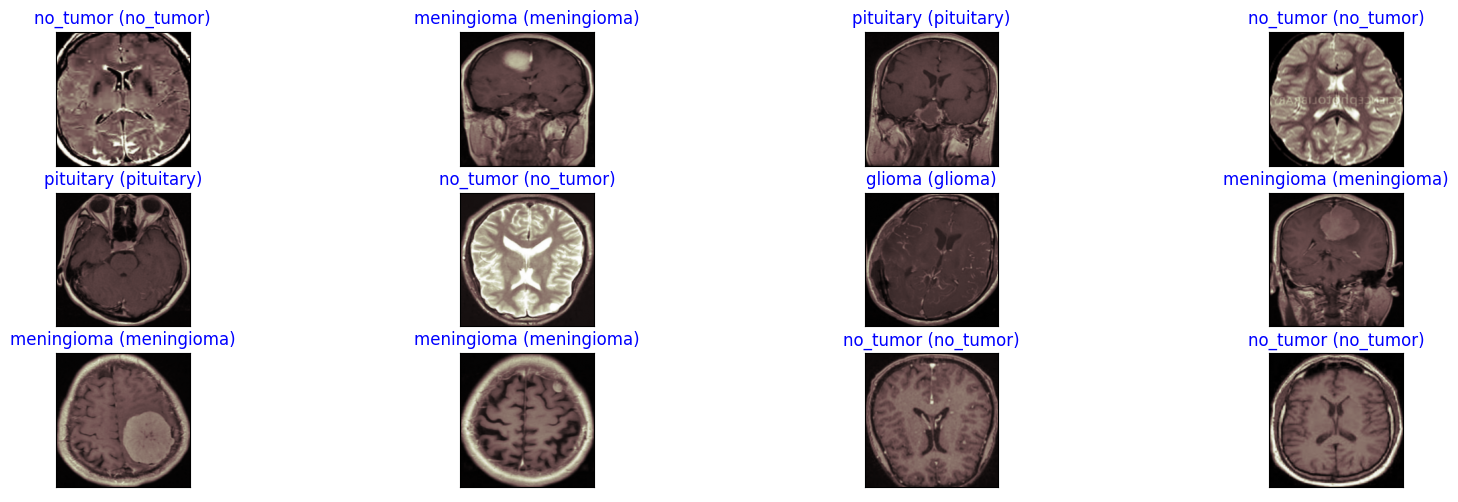

In [27]:
y_hat = model.predict(X_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

In [28]:
from tensorflow.keras.models import load_model
model = load_model('bestinception2.h5')

In [29]:
#Predicting a particiular image without image preprocessing
from tensorflow.keras.preprocessing import image
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor'] 
path ='.\Dataset\cropped\Testing\pituitary\Te-pi_0294.jpg'
img=image.load_img(path,target_size=(200,200))
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x,axis=0)
predict_image1 = model.predict(x)
indices1 = np.argmax(predict_image1,axis = 1)
print(labels[indices1[0]])


pituitary_tumor


In [30]:
#Count Prediction time
import os
import time
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Define the labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Define the directories
directories = {
    'glioma': './Dataset/Testingprediction/glioma',
    'meningioma': './Dataset/Testingprediction/meningioma',
    'notumor': './Dataset/Testingprediction/notumor',
    'pituitary': './Dataset/Testingprediction/pituitary'
}

# Function to measure prediction time for images in a directory
def measure_prediction_time(model, directory):
    times = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, target_size=(200, 200))
        x = image.img_to_array(img)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)
        
        start_time = time.time()
        predict_image = model.predict(x)
        end_time = time.time()
        
        prediction_time = end_time - start_time
        times.append(prediction_time)
    
    return times

# Dictionary to store times for each category
prediction_times = {}

# Measure prediction times for each category
for label, directory in directories.items():
    times = measure_prediction_time(model, directory)
    prediction_times[label] = times

# Create a DataFrame to organize the results
results = {
    'Category': [],
    'Average Time (s)': [],
    'Max Time (s)': [],
    'Min Time (s)': []
}

for label, times in prediction_times.items():
    avg_time = np.mean(times)
    max_time = np.max(times)
    min_time = np.min(times)
    results['Category'].append(label)
    results['Average Time (s)'].append(avg_time)
    results['Max Time (s)'].append(max_time)
    results['Min Time (s)'].append(min_time)

# Add overall statistics
overall_times = [time for times in prediction_times.values() for time in times]
avg_time = np.mean(overall_times)
max_time = np.max(overall_times)
min_time = np.min(overall_times)
results['Category'].append('Overall')
results['Average Time (s)'].append(avg_time)
results['Max Time (s)'].append(max_time)
results['Min Time (s)'].append(min_time)

# Create a DataFrame and print it
df = pd.DataFrame(results)
print(df)


     Category  Average Time (s)  Max Time (s)  Min Time (s)
0      glioma          0.037912      0.042539      0.035001
1  meningioma          0.041930      0.182937      0.035206
2     notumor          0.040654      0.048742      0.037956
3   pituitary          0.040577      0.046999      0.037649
4     Overall          0.040268      0.182937      0.035001
